## SIR-X

Coronavirus COVID-19 is a pandemic that is spreading quickly worlwide. Up to the 29th of March, there are 666,211 cases confirmed, 30,864 deaths and 141,789 recovered people worldwide. Governments and citizens are taking quick decisions to limit the spread of the virus and minimize the number of infected and deaths. These decisions are taken based on the experts opinion, which justify their claims based in the results of predictive models.


This Jupyter Notebook is an effort to decrease the access barriers to state of the art yet simple models that can be used to take public policy decisions to limit disease spread and save lives. 

### SIR model

Most epidemic models share a common approach on modelling the spread of a disease. The SIR model is a simple deterministic compartmental model to predict disease spread. An objective population is divided in three groups: the susceptible ($S$), the infected ($I$) and the recovered or removed ($R$). These quantities enter the model as fractions of the total population $P$:


$$ S = \frac{\text{Number of susceptible individuals}}{\text{Population size}}$$

$$ I = \frac{\text{Number of infected individuals}}{\text{Population size}}$$

$$ R = \frac{\text{Number of recovered or removed individuals}}{\text{Population size}}$$

As a pandemics infects and kills much more quickly than human natural rates of birth and death, the population size is assumed constant except for the individuals that recover or die. Hence, $S+I+R=P/P=1$. The pandemics dynamics is modelled as a system of ordinary differential equations which governs the rate of change at which the percentage of susceptible, infected and recovered/removed individuals in a population evolve.

The number of possible transmissions is proportional to the number of interactions between the susceptible and infected populations, $S \times I $:

$$\frac{dS}{dt} = -\alpha SI.$$

Where $\alpha$ is the reproduction rate of the process which quantifies how many of the interactions between susceptible and infected populations yield to new infections per day.

The population of infected individuals will increase with new infections and decrease with recovered or removed people. 

$$\frac{dI}{dt} = \alpha S I  - \beta I, $$
$$\frac{dR}{dt} = \beta I. $$

Where $ \beta $ is the percentage of the infected population that is removed from the transmission process per day.

In early stages of the infection, the number of infected people is much lower than the susceptible populations. Hence, $S \approx 1$ making $dI/dt$ linear and the system has the analytical solution $I(t) = I_0 \exp (\alpha - \beta)t$.



#### Numerical implementation - SIR model

Three python packages are imported: numpy for numerical computing, matplotlib.pyplot for visualization and the numerical integration routine odeint from scipy.integrate:

In [1]:
import numpy as np # Numerical computing
import matplotlib.pyplot as plt # Visualization
from scipy.integrate import odeint # ODE system numerical integrator
from scipy.optimize import curve_fit # Minimize squared errors using LM method

Implementing systems of ordinary differential equations (ODEs) in python is straightforward. First, a function is created to represent the system inputs and outputs. The inputs of the function are a vector of state variables ${\vec{w}}$, the independent variable $t$ and a vector of parameters $\vec{p}$. The output of the function must be the right hand side of the ODE system as a list.

Following this approach, the SIR model can be implemented as it follows:

$$ \vec{w} = [S,I,R]$$
$$ \vec{p} = [\alpha, \beta] $$

And $t$ enters directly. The function return will be the list of ODEs.

$$\vec{f} = \left[ \frac{dS}{dt}, \frac{dI}{dt}, \frac{dR}{dt} \right]$$

So $\vec{f} = \text{sir}(\vec{w}, t, \vec{p})$.

The solution of this system is a vector field $\vec{w} = [S(t),I(t),R(t)]$. In day to day words, it gives the percentage of the population who are susceptible (S), infected (I) and recovered or removed R(t) as a function of time. There is no analytical solution for this system. However, a numerical solution can be obtained using a numerical integrator. In this implementation, the function scipy.odeint is used to integrate the differential system. The ODE system of the SIR model was implemented in the function sirx(t,w,p) on the module model.py. The solver is implemented in the function _solve on the module model.py.


### SIR-X model

A new epidemic model based in SIR, SIRX, was developed by the [Robert Koch Institut](http://rocs.hu-berlin.de/corona/docs/forecast/model/#sir-x-dynamics-outbreaks-with-temporally-increasing-interventions) and is implemented in what follows. A full description of the model is available in the [Robert Koch Institut SIRX model webiste](http://rocs.hu-berlin.de/corona/docs/forecast/model/#sir-x-dynamics-outbreaks-with-temporally-increasing-interventions).

The ODE system of the SIR-X model was implemented in the function sirx(t,w,p) on the module model.py

In [2]:
import model
from model import _solve #?

class Model:
    
    def __init__(self, p, w0):
        self.setmodel()
        self.p = p
        self.w0 = w0
        
    
    def solve(self, tf_secs, numpoints):
        tspan = np.linspace(0,tf_secs,numpoints)
        
        a = _solve(self.func, self.p, self.w0,
                     tspan, numpoints)
        return a
    
    @property
    def R_0(self):
        """ Returns reproduction number
        R_0 = alpha/beta"""
        return self.p[0]/self.p[1]
    
    def fit(self, t_obs, n_I_obs, population, inplace=False):
        """ Use the Levenberg-Marquardt algorithm to fit
        the parameter alpha, as beta is assumed constant
        
        inputs:
        t_obs: Vector of days corresponding to the observations of number of infected people
        n_I_obs: Vector of number of infected people
        population: Size of the objective population
        
        Returns
        """
        
        secs_obs = t_obs*3600*24
        
        def function_handle(t, alpha, beta = self.p[1], population=population):
            p = [alpha,beta]
            I_mod = _solve(self.func, p, self.w0,
                           t, numpoints=len(t_obs))
            n_I_mod = I_mod[:,2]*population
            return n_I_mod
        
        # Fit alpha
        alpha_opt, pcov = curve_fit(f = function_handle,
                        xdata = secs_obs, ydata = n_I_obs, p0=self.p[0])
        p_new = [i for i in self.p] 
        p_new[0] = alpha_opt[0]
        self.p=p_new
        return 
        # return p_new, pcov
            
    pass

class SIR(Model):
    def setmodel(self):
        self.func = model.sir
    pass

class SIRX(Model):
    def setmodel(self):
        self.func = model.sirx
    pass

### Usage example



#### Case study

The borough of Ealing, in London, is selected arbitrarly as one of the authors is living there at the moment. According to the UK office for National Statistics, the population of Ealing by mid-year 2018 is [342,000](https://www.ealing.gov.uk/info/201048/ealing_facts_and_figures/2184/population_and_households/1). The number of reported infections at 29/03/2020 is 241.

#### Model parameters
As an implementation examples, the parameter $\beta$ is estimated from the methodology followed by the [Robert Koch Institut SIRX model webiste](http://rocs.hu-berlin.de/corona/docs/forecast/model/#sir-x-dynamics-outbreaks-with-temporally-increasing-interventions). The institute estimated the a removal rate value $\beta = 0.38/d$ (mean infections time $T_I = 1/\beta = 2.6d)$ based on one third of the reported average infections preioud of moderate cases in Mainland China.

The reproduction number is fixed $R_0 = \alpha / \beta = 2.5$ as a first approximation. 

Please note that the predictions of this model shouldn't be taken in consideratin, as the SIR model doesn't consider dynamic variation of model parameters, which is observed in reality.

### Solution and implementation
The aim of this API is to provide an user friendly approach to build a SIR model and fit it to a target dataset in order to make predictions in few lines of code.


In [3]:
# Use Ealing as an example to determine model initial conditions
Ealing_data = [8, 18, 20, 18, 21, 42, 53, 54, 80, 97, 106, 123, 136, 165, 209, 241] # N_of infected

P_Ealing = 342000 # Ealing population ONS 2018 mid year
I_Ealing = 8      # Infected people at 14/03/2020
R_Ealing = 0      # Recovered people at 29/03/2020
n_days = len(Ealing_data)

# Input parameters
beta = 0.38 # Per day
alpha = 2.5 * beta # WHO estimate

#### Calculate model parameters and initial conditions

In [4]:
# Calculate initial conditions in terms of population fraction
S0 = (P_Ealing-I_Ealing)/P_Ealing
I0 = I_Ealing/P_Ealing
R0 = R_Ealing/P_Ealing      # Recovered people

# Construct vector of parameters
p = [alpha, beta]

# Construct vector of initial conditions
w0 = [S0, I0, R0]

### Build the model with the default parameters and predict the number of susceptible, infected and recovered people in the Ealing borough.

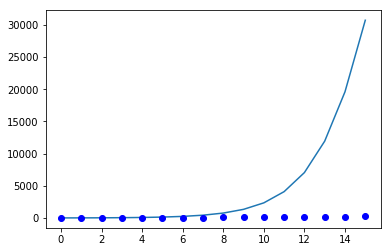

2.5

In [5]:
from model import SIR, SIRX

In [ ]:
# Build a SIR model
my_SIR = SIR(p,w0)
# Call model.solve functions with the time in seconds (tf) and the number of points where the solution will be evaluated
sol = my_SIR.solve(n_days-1, n_days)
# Unpack the numerical solution for the susceptible (S), infected (I) and recovered or removed (R)
S_sir = sol[:,1]
I_sir = sol[:,2]
R_sir = sol[:,3]
# Convert the ratio to population
N_I_sir = I_sir*P_Ealing
# Plot the results
# Define array of days. Note that the initial day is the day "zero", so 
# the final day is the number of days minus one. This is divided in n_days
# intervals to be consistent with the input
days_list = np.linspace(0, n_days-1, n_days)
plt.plot(days_list, N_I_sir)
plt.plot(days_list, Ealing_data,'bo')
plt.show()
my_SIR.r0

If the default parameters are used, the results are completely unreliable. Indeed, the model predicts more than 150 times more people infected. This is why a model shouldn't be used blindly, and always the parameters must be checked. In UK, Social distancing started voluntarily on the 16th of February, and the lockdown started on the 23rd of February. The effect of this policy change in terms of our model, is a decrease in the reproduction rate $R_0 = \alpha / \beta$. As the national health system (NHS) of UK didn't reach full capacity on the period between the 15th and the 29th of March, it is reasonable to assume that the main change occured owing to a decrease in the transmission rate $\alpha$.

To obtain a more realistic approximation, the parameter can be modified to better reproduce the observed data. This process is named **parameter fitting** and it is widely used not only on epidemiology, but in any discipline which uses mathematical models to make prediction. 


The function model.fit() enables to fit the desired parameters to a certain dataset. The parameter fitting is straightforward using open-sir:

### Parameter Fitting 
Fitting $R_0$ through $\alpha$ keeping $\beta$ constant

In the following case study, $R_0$ will be fitted to minimize the mean squared error between the model predictions and UK historical data on the Ealing borough in the time period between the 15th and the 29th of March of 2020.

Fitted reproduction rate R_0 = 1.61


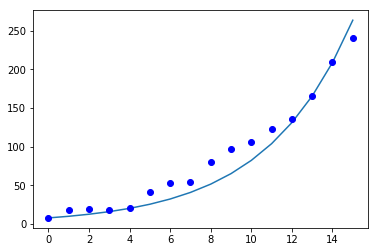

In [6]:
Ealing_data

In [ ]:
# Create SIR with default parameters
my_SIR_fitted = SIR(p,w0)
# Create a vector of times
# t = np.linspace(0, tf,numpoints)
# Fit parameters
w = my_SIR_fitted.fit(days_list, Ealing_data, P_Ealing)
# Print the fitted reproduction rate
print("Fitted reproduction rate R_0 = %.2f" % my_SIR_fitted.r0)
# Build the new solution
sol = my_SIR_fitted.solve(n_days-1, n_days)
# Plot the results

plt.plot(days_list,sol[:,2]*P_Ealing)
plt.plot(days_list,Ealing_data,'bo')
plt.show()

In [ ]:
my_SIR

## DANGER ZONE
### Example: predict the total number of infections and the time where the number of infected people is maximum

This is extremely dangerous as $R_0$ is extremely likely to change with time. However we have seen many people taking decisions in this kind of analysis. Use it at your own risk and with a metric ton of salt.

In [7]:
long_term_days = 90
# Convert into seconds
tf_long = long_term_days-1
sol_long = my_SIR_fitted.solve(tf_long, long_term_days)
N_S_long = sol_long[:,1]*P_Ealing
N_I_long = sol_long[:,2]*P_Ealing
N_R_long = sol_long[:,3]*P_Ealing

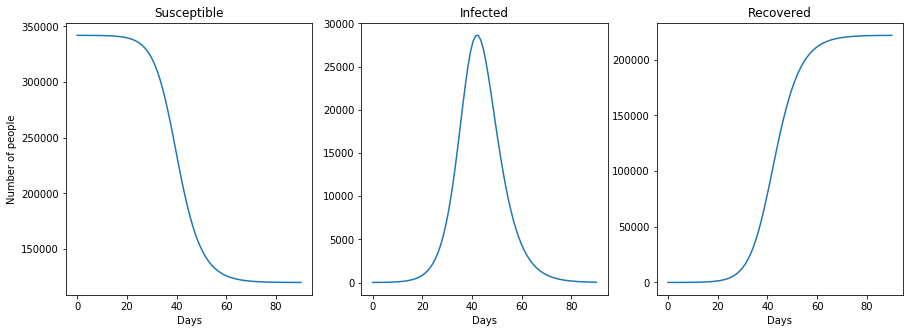

In [8]:
# Plot the number of susceptible, infected and recovered in a two months period
tspan_long = np.linspace(0,tf_long,long_term_days)
plt.figure(figsize=[15,5])
plt.subplot(1,3,1)
plt.plot(tspan_long,N_S_long)
plt.xlabel('Days')
plt.ylabel("Number of people")
plt.title("Susceptible")
plt.subplot(1,3,2)
plt.plot(tspan_long,N_I_long)
plt.xlabel('Days')
plt.title("Infected")
plt.subplot(1,3,3)
plt.plot(tspan_long,N_R_long)
plt.title("Recovered or removed")
plt.xlabel('Days')
plt.show()

It can be observed that the SIR model reproduces the all familiar infection bell, as well as the evolution of susceptible and recovered population. It is interesting to observe that if no measures are taken in a $R_0 = 1.47$ scenario, 65% of the Ealing population would be infected in three months.

### Sensitivity to $R_0$

A known weakness of all pandemics prediction model is the sensitivity to their parameters. In the following case study, $R_0$ will be fitted to minimize the mean squared error between the model predictions and UK historical data on the Ealing borough in the time period between the 15th and the 29th of March of 2020.

In [9]:
def compare_infections(model, tf, numpoints, alpha_list=2.5, abserr=1e-8, relerr=1e-6):
    """ compare_infections compare SIR model predictions against
    a list of alpha values
    
    Inputs:
    w0: Initial conditions
    t: Time vector /
    alpha_list: list or numpy array of values of alpha to be tested
    
    Outputs:
    S_list: List of predictions for the fraction of susceptible population for each alpha
    I_list: List of predictions for the fraction of infected population for each alpha
    R_list: List of predictions for the fraction of recovered/removed population for each alpha
    """
    S_list = []
    I_list = []
    R_list = []
    
    for i in alpha_list:
        # Update parameter list
        model.p[0] = i
        wsol = model.solve(tf,numpoints)
        S_list.append(wsol[:,1])
        I_list.append(wsol[:,2])
        R_list.append(wsol[:,3]) 
    return S_list, I_list, R_list

### Generate predictions for each alpha

In [10]:
alpha_list = beta*np.array([1.5,1.6,1.7])
S_list, I_list, R_list = compare_infections(my_SIR, tf_long, long_term_days, alpha_list)

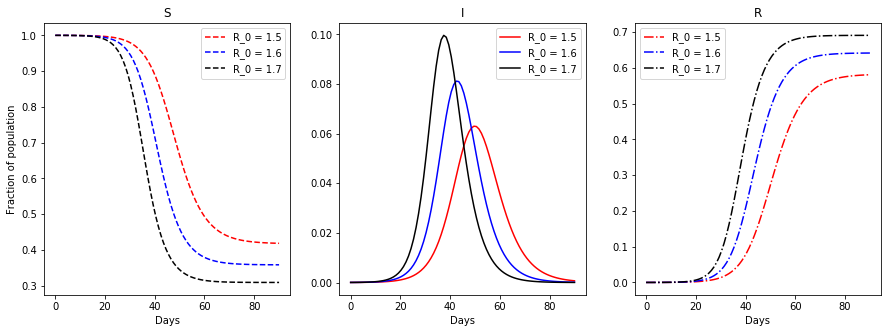

In [11]:
col = ['r','b','k']
plt.figure(figsize=[15,5])
for i in range(len(S_list)):
    plt.subplot(1,3,1)
    plt.plot(tspan_long,S_list[i], col[i]+"--")
    plt.legend(['R_0 = 1.5','R_0 = 1.6','R_0 = 1.7']) 
    plt.xlabel('Days')
    plt.ylabel('Fraction of population')
    plt.title('S')
    plt.subplot(1,3,2)
    plt.plot(tspan_long,I_list[i], col[i])
    plt.legend(['R_0 = 1.5','R_0 = 1.6','R_0 = 1.7']) 
    plt.xlabel('Days')
    plt.title('I')
    plt.subplot(1,3,3)
    plt.plot(tspan_long,R_list[i], col[i]+"-.")
    plt.legend(['R_0 = 1.5','R_0 = 1.6','R_0 = 1.7']) 
    plt.xlabel('Days')
    plt.title('R')

We observe that a change as little as 6% in the reproduction rate, can change dramatically the dynamic of the pandemic

### Example 4: Fit R_0 for UK values
[sourced from UK Arcgis](https://www.arcgis.com/apps/opsdashboard/index.html#/f94c3c90da5b4e9f9a0b19484dd4bb14)

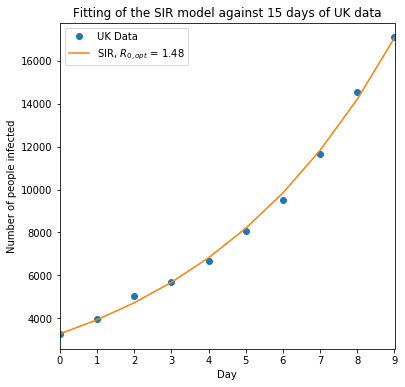

Mean squared error on the predictions 147.51


In [12]:
P_UK = 67886011
# Data up to 28th of March
I_UK= [3269, 3983, 5018, 5683, 6650, 8077, 9529, 11658, 14543, 17089]
n_days = len(I_UK) # Final day
t_d = np.linspace(0,n_days-1,n_days)

S0 = (P_UK-I_UK[0])/P_UK
I0 = I_UK[0]/P_UK
w0 = [S0, I0, R0]
p = [alpha,beta]

# Create empty model
SIR_UK = SIR(p, w0)
# Train model
SIR_UK.fit(t_d, I_UK, P_UK)
# Build numerical solution
I_opt = SIR_UK.solve(n_days-1,n_days)[:,2]*P_UK
# lag = 6

R_opt = SIR_UK.r0 # 

plt.figure(figsize=[6,6])
plt.plot(t_d,I_UK,'o')
plt.plot(t_d, I_opt)
plt.legend(["UK Data","SIR, $R_{0,opt}$ = %.2f"%R_opt])
plt.title("Fitting of the SIR model against 15 days of UK data")
plt.ylabel("Number of people infected")
plt.xlabel("Day")
plt.xlim([min(t_d),max(t_d)])
plt.show()


In [ ]:
MSE = sum(np.sqrt((I_opt-I_UK)**2))/len(I_UK)        
print("Mean squared error on the model in the train dataset %.2f" % MSE)

### Calculate confidence intervals



In [13]:
from post_regression import ci_bootstrap

In [ ]:
# Get the confidence interval through bootstrap
par_ci, par_list = ci_bootstrap(SIR_UK, t_d, I_UK, P_UK, n_iter=1000)

In [14]:
alpha_min = par_ci[0][0]
alpha_max = par_ci[0][1]
# Explore the confidence intervals
print("IC 95% for alpha:", par_ci[0])
print("IC 95% for beta:", par_ci[1])
print("IC 95% for r0:", par_ci[2])

Number of infected people predicted 29597 after 3 days
The mean squared error of the model is 148


Now we can visualize

In [ ]:
# Build numerical solution
I_opt = SIR_UK.solve(n_days-1, n_days)[:,2]*P_UK
beta_0 = SIR_UK.p[1]
SIR_minus = SIR([alpha_min, beta_0],w0)
SIR_plus = SIR([alpha_max, beta_0],w0)
I_minus = SIR_minus.solve(n_days-1, n_days)[:,2]*P_UK
I_plus = SIR_plus.solve(n_days-1, n_days)[:,2]*P_UK

# lag = 6

R_opt = SIR_UK.r0 # 

plt.figure(figsize=[6,6])
plt.plot(t_d,I_UK,'o')
plt.plot(t_d, I_opt)
plt.plot(t_d, I_minus)
plt.plot(t_d, I_plus)
plt.legend(["UK Data","SIR, $R_{0,opt}$ = %.2f"%R_opt,"IC_95-","IC_95+"])
plt.title("Fitting of the SIR model against 15 days of UK data")
plt.ylabel("Number of people infected")
plt.xlabel("Day")
plt.xlim([min(t_d),max(t_d)])
plt.show()

An extremely asymmetrical confidence interval for $R_0$ using simple random bootstrap is observed. This occurs most likely because of 
neglecting the temporal structure of the exponential.

To further investigate this phenomena, we can observe the distribution of the $R_0$ parameter on the parameter list

In [ ]:
plt.hist(par_list[:,0]/par_list[:,1], bins=50, density=True, stacked=True)
plt.xlabel('$R_0$')
plt.ylabel('Frequency')
plt.title("Probability density diagram of $R_0$ bootstrapping")
plt.show()

It is interesting to observe that the spread is assymetrical towards lower $R_0$ values. This asymmetry is expected owing to the effect of lockdowns and public policies to promote social distancing. A strong assumption of the SIR model is that the spread rate $\alpha$ and removal rate $\beta$ are constant, which is not the case in reality specially when strong public policies to limit the spread of a virus take place.

In [ ]:
# par_ci, par_list = ci_bootstrap(SIR_UK, t_d, I_UK, P_UK, n_iter=1000)
from post_regression import ci_block_cv
MSE_avg, MSE_list, p_list = ci_block_cv(SIR_UK, t_d, I_UK, P_UK, lag=1)

In [ ]:
p_list

In [ ]:
print("The average mean squared error on the time cross validation bootstrapping is: %.3f" % MSE_avg)

We can visualize the results of the block bootstrapping in terms of the variation of the reproduction rate $R_0$ and the mean squared error when a subset of the days is taken. By default, ci_block_cv starts with the data of the three days, fit the model on that data, predicts the number of infected in the next period, calculate the mean squared error between the prediction and the test dataset, and stores it into two arrays. It repeats this until it uses the data of $(n-1)$ intervals to predict the $n-th$ latest observation of infections.

In [ ]:
r0_roll = p_list[:,0]/p_list[:,1]

plt.figure(figsize=[10,5])
plt.subplot(1,2,1)
plt.plot(t_d[3:], r0_roll,'ro')
plt.xlabel("Days used in the block to fit parameters")
plt.ylabel("Rolling $R_0$")
plt.title("Block bootstrapping change in $R_0$")
plt.subplot(1,2,2)
plt.plot(MSE_list,'bo')
plt.xlabel("Days used in the block to fit parameters")
plt.ylabel("Mean squared error in number of infected")
plt.title("Block bootstrapping change in MSE")
plt.show()

### Calculate confidence intervals



In [15]:
y = [0,1,2,3,4]

In [16]:
from sklearn.utils import resample
resample(y)

[1, 4, 0, 2, 3]

In [17]:
I_rUK = resample(I_UK)

In [18]:
p_bt = []
R_0_bt = []
n_iter = 100

SIR_BS = SIR(p, w0)


for i in range(0,n_iter):
    t_r, I_r = resample(t_d, I_UK)
    I_r = np.array(I_r)
    # Sort and redefine arrays
    idx = np.argsort(t_r)
    t_rs = t_r[idx]
    I_rs = I_r[idx]
    SIR_BS.fit(t_rs, I_rs, P_UK)
    p_bt.append(SIR_BS.p)
    R_0_bt.append(SIR_BS.R_0)

In [19]:
SIR_BS.p

[6.5260428198408524e-06, 4.398148148148148e-06]

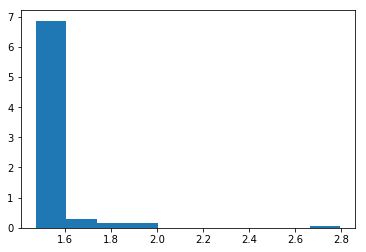

In [20]:
plt.hist(R_0_bt, bins=10,   density=True)
plt.show()

In [21]:
p2=np.array(p_bt)

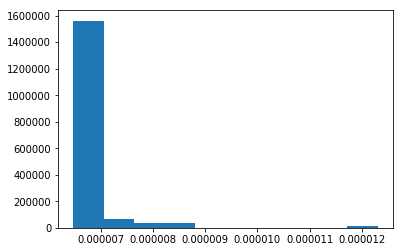

In [22]:
plt.hist(p2[:,0], bins=10,   density=True)
plt.show()

In [23]:
from post_regression import ci_bootstrap

In [48]:
# Get the confidence interval through bootstrap
par_ci = ci_bootstrap(SIR_UK, t_d, I_rs, P_UK, n_iter=1000)


[[6.02015064e-06 7.29756367e-06]
 [4.39814815e-06 4.39814815e-06]
 [1.36879215e+00 1.65923553e+00]]


In [56]:
alpha_min = par_ci[0][0]
alpha_max = par_ci[0][1]
# Explore the confidence intervals
print("IC 95% for alpha:", par_ci[0])
print("IC 95% for beta:", par_ci[1])
print("IC 95% for r0:", par_ci[2])

IC 95% for alpha: [6.02015064e-06 7.29756367e-06]
IC 95% for beta: [4.39814815e-06 4.39814815e-06]
IC 95% for r0: [1.36879215 1.65923553]


Now we can visualize

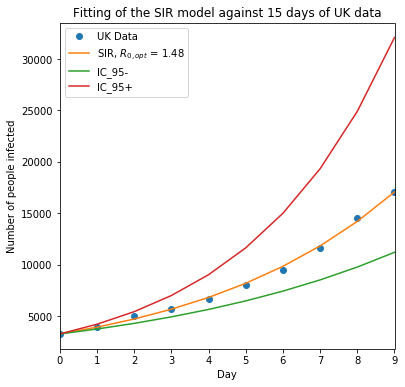

Mean squared error on the predictions 147.51


In [47]:
# Build numerical solution
I_opt = SIR_UK.solve(t_s[-1], 10)[:,2]*P_UK
beta_0 = SIR_UK.p[1]
SIR_minus = SIR([alpha_min, beta_0],w0)
SIR_plus = SIR([alpha_max, beta_0],w0)
I_minus = SIR_minus.solve(t_s[-1], 10)[:,2]*P_UK
I_plus = SIR_plus.solve(t_s[-1], 10)[:,2]*P_UK

# lag = 6

R_opt = SIR_UK.R_0 # 

plt.figure(figsize=[6,6])
plt.plot(t_d,I_UK,'o')
plt.plot(t_d, I_opt)
plt.plot(t_d, I_minus)
plt.plot(t_d, I_plus)
plt.legend(["UK Data","SIR, $R_{0,opt}$ = %.2f"%R_opt,"IC_95-","IC_95+"])
plt.title("Fitting of the SIR model against 15 days of UK data")
plt.ylabel("Number of people infected")
plt.xlabel("Day")
plt.xlim([min(t_d),max(t_d)])
plt.show()

I_UK-I_opt
MSE = sum(np.sqrt((I_opt-I_UK)**2))/len(I_UK)        
print("Mean squared error on the predictions %.2f" % MSE)

In [28]:
print("Mean squared error on the predictions %.2f" % MSE)

Mean squared error on the predictions 147.51
